# Architettura
    2 HIDDEN LAYER  
    4 + 4 NEURONI 
    ACTIVATION FUN: TANH  
    EPOCHE: 30000

In [1]:
import numpy as np
import pandas as pd
import functions as f
import torch
from torch import autograd, nn
import torch.optim as optim
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

# ALL DATASET
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")

**Definisco** `par` **il parametro che voglio studiare**

In [2]:
par = 'fwhm_y'

dataset = np.stack((data["x"].values, data["y"].values, data[par]), axis=1)
dataset = torch.from_numpy(dataset).float()

data_max = data[par].max()
data_min = data[par].min()

## PARAMETRI
Definisco ora tutti i parametri in modo che siano facilmente modificabili

In [3]:
input_size = 2
hidden_size1 = 4
hidden_size2 = 4
activation_fun = nn.Tanh()
epochs = 30000
loss_fun = nn.MSELoss()

Usando `torch.utils.data.DataLoader` il dataset iniziale viene suddiviso casualmente in modo tale che circa il 75% (126) dei dati finiscano nel training set e il 25% nel validation

In [4]:
loader = torch.utils.data.DataLoader(dataset, batch_size = 126, shuffle=True)
train, validation = loader
X_train = train[:,:2]
y_train = train[:,2]
y_train = f.normalization2(y_train, data_max, data_min)

X_val = validation[:,:2]
y_val = validation[:,2]
y_val = f.normalization2(y_val, data_max, data_min)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.activation = activation_fun
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size1, 1)
        
    def forward(self, input):
        hidden1 = self.hidden1(input)
        activated1 = self.activation(hidden1)
        hidden2 = self.hidden2(activated1)
        activated2 = self.activation(hidden2)
        output = self.output(activated2)
        
        return self.activation(output)

In [5]:
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001)

Funzione per inizializzare i pesi della rete

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0.0)

## TRAINING

In [7]:
net.eval()
net.apply(init_weights)

y_pred = net(X_val)
y_pred = torch.squeeze(y_pred)
before_train = loss_fun(y_pred, y_val)
print('Test loss before Training' , before_train.item())

net.train()

training_loss = []
validation_loss = []

for epoch in tqdm(range(epochs)):
    opt.zero_grad()
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = loss_fun(y_train, y_pred)
    training_loss.append(train_loss)

    with torch.no_grad():
        y_test = net(X_val)
        y_test = torch.squeeze(y_test)
        val_loss = loss_fun(y_val, y_test)
        assert val_loss.requires_grad == False
        validation_loss.append(val_loss)

    train_loss.backward()
    opt.step()
    
    # shuffle del training e validation set ogni 1000 epoche
    if epoch % 1000 == 0:
        loader = torch.utils.data.DataLoader(dataset, batch_size = 126, shuffle=True)
        train, validation = loader
        X_train = train[:,:2]
        y_train = train[:,2]
        y_train = f.normalization2(y_train, data_max, data_min)
        X_val = validation[:,:2]
        y_val = validation[:,2]
        y_val = f.normalization2(y_val, data_max, data_min)
    
net.eval()

y_pred = net(X_val)
y_pred = torch.squeeze(y_pred)
after_train = loss_fun(y_pred, y_val)
print('Test loss after Training' , after_train.item())
if before_train < after_train:
    print('OVERFITTING')
else:
    print('Everything is ok')

  0%|          | 20/30000 [00:00<02:35, 193.26it/s]

Test loss before Training 0.7971845865249634


100%|██████████| 30000/30000 [00:58<00:00, 513.33it/s]

Test loss after Training 0.011275202967226505
Everything is ok


## Plot Loss

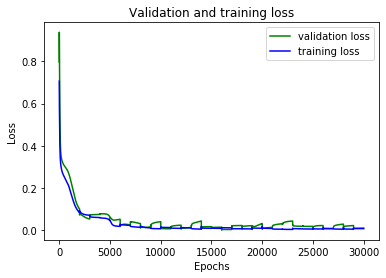

In [8]:
plt.plot(validation_loss, linestyle='-', color='green', label='validation loss')
plt.plot(training_loss, linestyle='-', color='blue', label='training loss')
plt.title('Validation and training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Plot Error

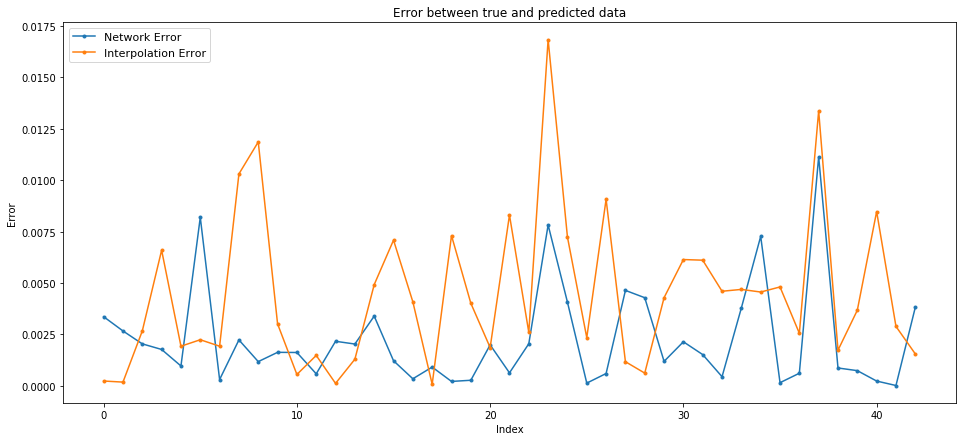

In [9]:
predicted = torch.squeeze( net(X_val).float() )
true = torch.squeeze( y_val.float() )

# inverto la normalizzazione in modo da tornare al dominio di partenza
predicted = f.inverse_normalization2(predicted, data_max, data_min)
true = f.inverse_normalization2(true, data_max, data_min)

t = [np.array(X_train[:,0]), np.array(X_train[:,1])]
v = [np.array(X_val[:,0]), np.array(X_val[:,1])]
popt, pcov = curve_fit( f.func, t, f.inverse_normalization2(np.array(y_train), data_max, data_min ))
function = f.func(v, *popt)

err_net = abs(predicted - true).detach().numpy()
err_int = np.array(abs(function - f.inverse_normalization2(np.array(y_val), data_max, data_min )))

fig = plt.figure(figsize=(16, 7))
plt.plot(err_net, marker='.', ls='-', label='Network Error')
plt.title('Error between true and predicted data')
plt.xlabel('Index')
plt.ylabel('Error')
plt.plot(err_int, marker='.', ls='-', label='Interpolation Error')
plt.legend(loc='upper left', fontsize=11)

In [10]:
err = np.stack((err_net, err_int), axis=1)

np.savetxt('./ErrorPlot/Tanh_2L_fwhmy', err)